In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.optim as optim

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random 


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as models_rf

import data_utils.data_analysis as data_analysis

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

## Loading the dataset

In [3]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [4]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

### Pulse reconstruction

In [5]:
#time in fs (it is the boundary)
#using DASK to accelerate computing
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [6]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [7]:
filename_pulse='datasets/pulse_240918.h5'

In [8]:
#read the data
df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots whith bad goodness

In [9]:
df_input_reduced=df_input[df_input['goodness']>1.3]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [10]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163188,34400.0,-23000.0,-4900000.0,1.418891
3,163189,34400.0,-23000.0,-4600000.0,1.335844
4,163192,34400.0,-23000.0,-4600000.0,1.333817
...,...,...,...,...,...
2711,172480,35400.0,19000.0,-5500000.0,1.330710
2712,172481,35400.0,19000.0,-5500000.0,1.365691
2713,172482,35400.0,19000.0,-5500000.0,1.357783
2714,172483,35400.0,19000.0,-5500000.0,1.319961


In [11]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

In [12]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cuda


## Forward model

In [13]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    #y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf#,df_error_forward_rf

In [14]:
%%time
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 2.83 s, sys: 111 ms, total: 2.94 s
Wall time: 2.94 s


# Roundtrip models

**Random Forest**

In [15]:
%%time
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)
mae_error_round=roundmodel_rf.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 1min 15s, sys: 134 ms, total: 1min 15s
Wall time: 1min 15s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**MLP**

In [16]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)
error_round_model_mlp=roundmodel_mlp.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.04895058646798134
Finished epoch 20,latest loss 0.0009197225444950163
Finished epoch 40,latest loss 0.0006255584303289652
Finished epoch 60,latest loss 0.0005448057781904936
Finished epoch 80,latest loss 0.0005026695434935391
Finished epoch 99,latest loss 0.0004712882509920746
Total time taken to train the model: 2.83s
Training the backward model
Finished epoch 0,latest loss 1.0266259908676147
Finished epoch 50,latest loss 0.04834528639912605
Finished epoch 100,latest loss 0.025807039812207222
Finished epoch 150,latest loss 0.018347958102822304
Finished epoch 200,latest loss 0.014167208224534988
Finished epoch 250,latest loss 0.011845044791698456
Finished epoch 300,latest loss 0.011573396623134613
Finished epoch 350,latest loss 0.009128930978477001
Finished epoch 399,latest loss 0.008996693417429924
Total time taken to train the model: 6.51s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

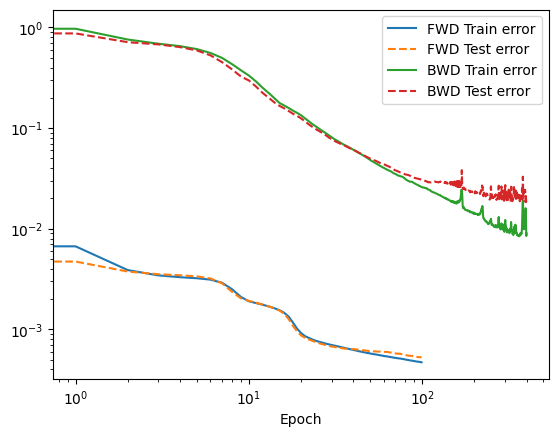

In [17]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Random guess models (+RF FWD)

In [18]:
## Random guess 'model'
o2min=X_test['order2'].min()
o2max=X_test['order2'].max()
o3min=X_test['order3'].min()
o3max=X_test['order3'].max()
o4min=X_test['order4'].min()
o4max=X_test['order4'].max()

o2_list=[]
o3_list=[]
o4_list=[]
for i in range(len(X_test)):
    o2_list.append(random.uniform(o2min,o2max))
    o3_list.append(random.uniform(o3min,o3max))
    o4_list.append(random.uniform(o4min,o4max))

X_test_rand=pd.DataFrame({'order2':o2_list,'order3':o3_list,'order4':o4_list})#,o3_list,o4_list])#,columns=['order2','order3','order4'])

#Pass those predicted (but random) beta values to the forward model
y_pred_fwd_rand=models_rf.make_rf_prediction(forward_model_rf,X_test_rand)
#calculate the error (Mean Absolute Error)
error_rand=abs(y_test-y_pred_fwd_rand)
error_rand=error_rand.sum(axis=1)/y_test.shape[1]

### CVAE

In [19]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)

batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
summary(cvae,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 244]                 --
│    │    └─Linear: 3-1                  [10, 244]                 50,020
│    │    └─LeakyReLU: 3-2               [10, 244]                 --
│    └─Sequential: 2-2                   [10, 204]                 --
│    │    └─Linear: 3-3                  [10, 204]                 49,980
│    │    └─LeakyReLU: 3-4               [10, 204]                 --
│    └─Sequential: 2-3                   [10, 102]                 --
│    │    └─Linear: 3-5                  [10, 102]                 20,910
│    │    └─LeakyReLU: 3-6               [10, 102]                 --
│    └─Sequential: 2-4                   [10, 51]                  --
│    │    └─Linear: 3-7                  [10, 51]                  5,253


In [20]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cuda
Finished epoch 0,latest loss 0.559226930141449
Finished epoch 20,latest loss 0.05123733729124069
Finished epoch 40,latest loss 0.04007400944828987
Finished epoch 60,latest loss 0.030805615708231926
Finished epoch 80,latest loss 0.023306287825107574
Finished epoch 100,latest loss 0.018734710291028023
Finished epoch 120,latest loss 0.01715470291674137
Finished epoch 140,latest loss 0.01737147383391857
Finished epoch 160,latest loss 0.018076403066515923
Finished epoch 180,latest loss 0.013392951339483261
Finished epoch 200,latest loss 0.013262203894555569
Finished epoch 220,latest loss 0.00968659296631813
Finished epoch 240,latest loss 0.009921034798026085
Finished epoch 260,latest loss 0.009301668964326382
Finished epoch 280,latest loss 0.008433131501078606
Finished epoch 299,latest loss 0.010340175591409206
Total time taken to train the model: 32.03s


Text(0.5, 0, 'Epoch')

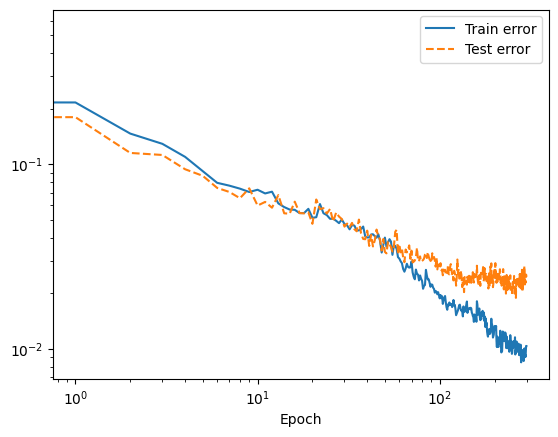

In [21]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Predictions

In [22]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      35200.0
order3       7000.0
order4   -4900000.0
Name: 2137, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


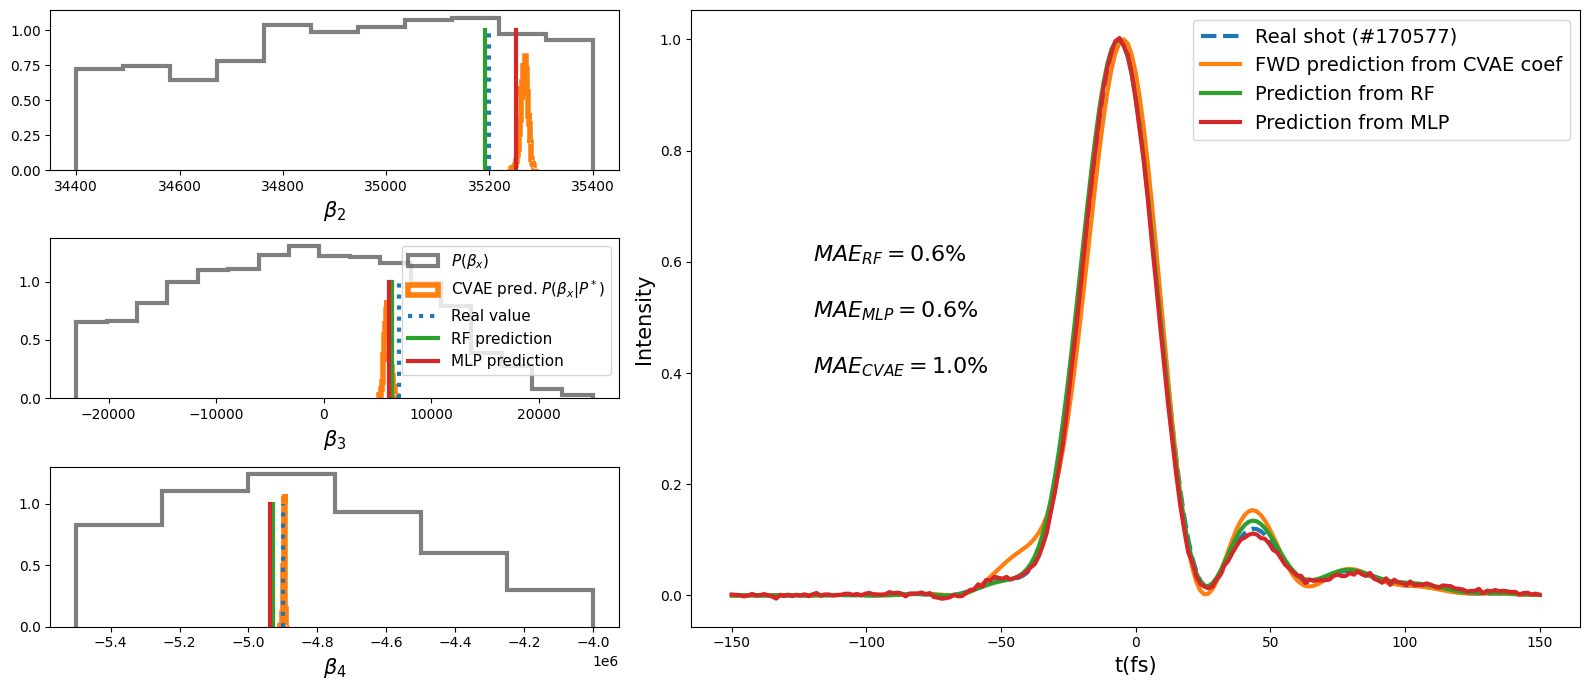

In [23]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

201
Known Dazzler values order2      34600.0
order3     -17000.0
order4   -4600000.0
Name: 423, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


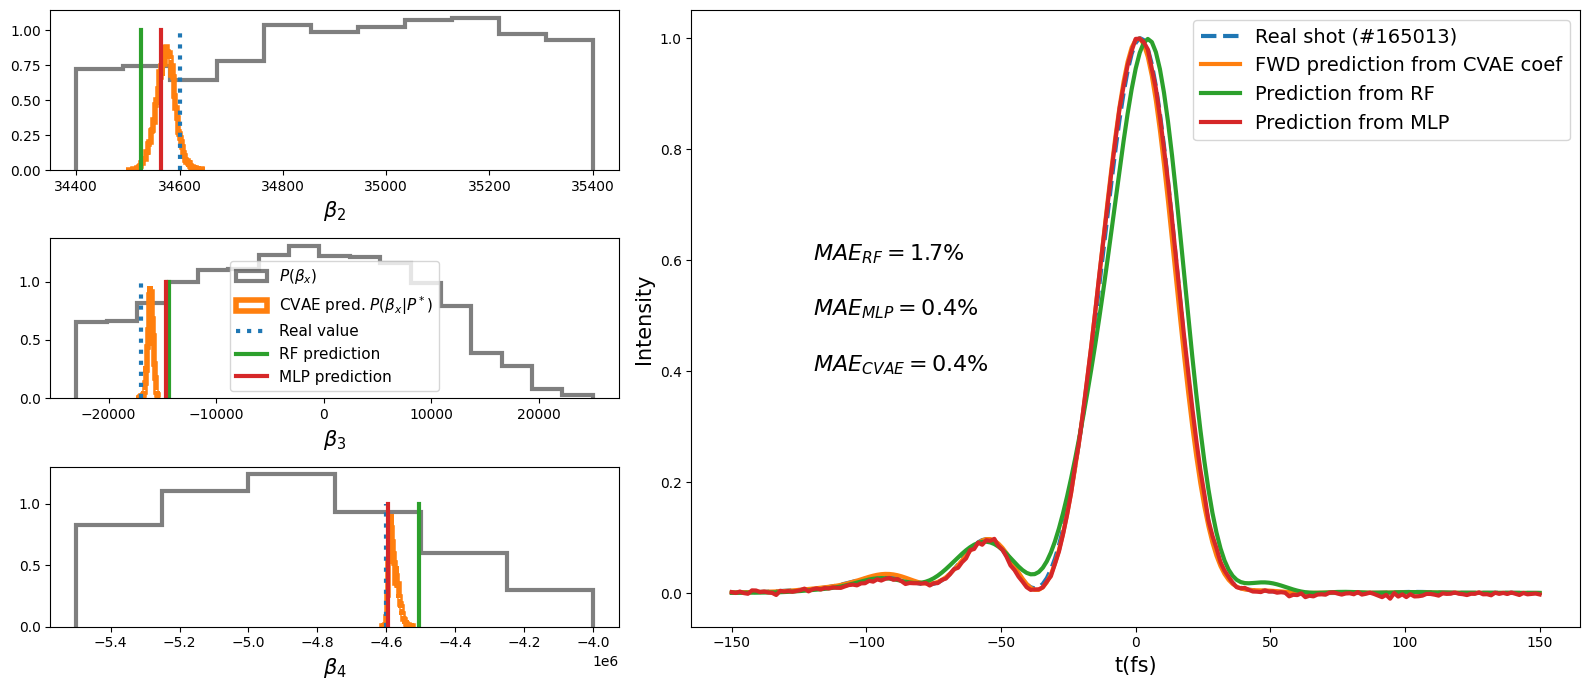

In [24]:
index_shot=125
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

### Calculate error in CVAE model

In [25]:
# The function gets the Y from a given shot. Predicts its X values. Then uses those X to reconstruct a pulse Y
#        using the forward model. Finally calculates the error from the predictiona dn real Y
#NOTE: X_train is the data that was used to normalized the X values
def get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device):
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex.values)))

    #Build the distributions functions P(D|p*)
    num_samples=10000
    #dazz_out_list=[]
    #for i in range(num_samples):
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)
        #dazz_out_list.append(dazz_out[0])
    #dazz_out_list=np.vstack(dazz_out_list)
    #P(D|p*) for each coefficient
    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #get the highest prob value from those distr
    num_bins=100
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #Pass those predicted beta values to the forward model
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)],columns=['order2', 'order3', 'order4']))[0]
    #calculate the error (Mean Absolute Error)
    error=abs(y_ex-y_pred_fwd_cvae)
    error=error.sum()/len(error)
    return error

In [26]:
%%time
#num_test_shots=500
cvae_error=[]
for i in range(len(y_test)):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device)
    cvae_error.append(error_pred_cvae)
cvae_error=np.array(cvae_error)

CPU times: user 2min 18s, sys: 138 ms, total: 2min 18s
Wall time: 12.2 s


## Comparison different models

/tmp/ipykernel_13640/3631300029.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'Model Accuracy (round trip)')

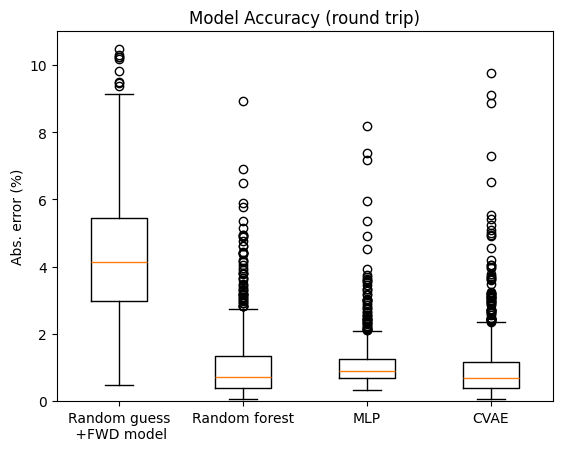

In [27]:
error_dist=[100*error_rand,
            100*mae_error_round,
            100*error_round_model_mlp,
            100*cvae_error]
labels=['Random guess\n +FWD model','Random forest','MLP','CVAE']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,11)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (round trip)')

0      0.045915
1      0.046102
2      0.051315
3      0.102374
4      0.041380
         ...   
810    0.064137
811    0.041645
812    0.034969
813    0.032771
814    0.009011
Length: 815, dtype: float64


(0.0, 6.0)

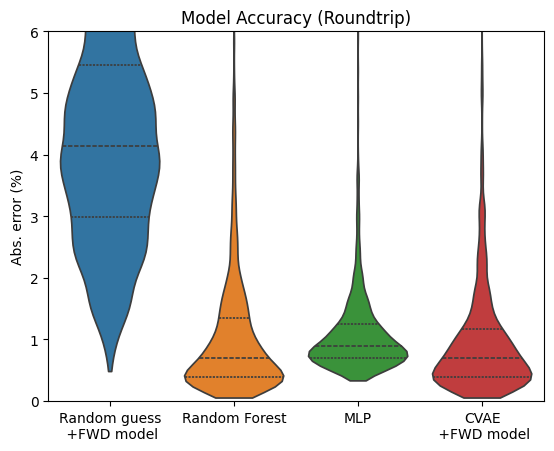

In [28]:
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=False,orient='v')
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.ylim(0,6)

0      0.045915
1      0.046102
2      0.051315
3      0.102374
4      0.041380
         ...   
810    0.064137
811    0.041645
812    0.034969
813    0.032771
814    0.009011
Length: 815, dtype: float64


(0.0, 6.0)

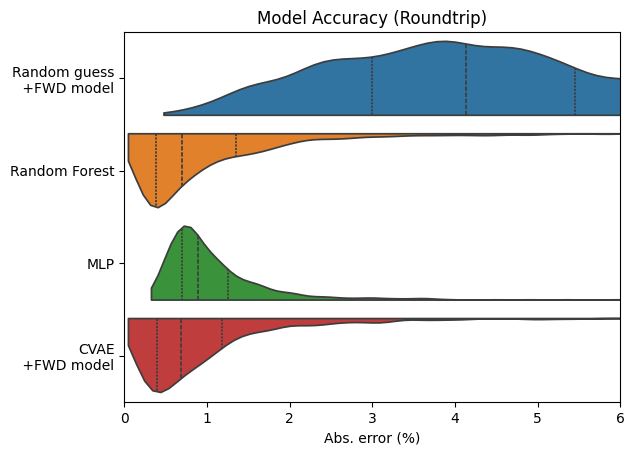

In [29]:
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,6)

## Different dataset size impact

In [30]:
def drop_shots(drop_factor,df_input,df_time):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [31]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 1494
The datasize is no: 1087
The datasize is no: 517


In [32]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=models_tools.split_dataset_roundtrip(df_input_subset_1500,df_time_subset_1500,rand_split=False)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=models_tools.split_dataset_roundtrip(df_input_subset_1k,df_time_subset_1k,rand_split=False)
X_train_500, X_test_500, y_train_500, y_test_500=models_tools.split_dataset_roundtrip(df_input_subset_500,df_time_subset_500,rand_split=False)

In [33]:
# Training the Random Forest forward models
forward_model_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

### RF

In [34]:
%%time
roundmodel_rf_1500=models_rf.ROUNDmodelRF(X_train_1500,X_test_1500,y_train_1500,y_test_1500)
roundmodel_rf_1500.train()
y_predict_round_1500=roundmodel_rf_1500.predict(y_test_1500)
mae_error_round_rf_1500=roundmodel_rf_1500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 37.9 s, sys: 114 ms, total: 38 s
Wall time: 38 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [35]:
%%time
roundmodel_rf_1k=models_rf.ROUNDmodelRF(X_train_1k,X_test_1k,y_train_1k,y_test_1k)
roundmodel_rf_1k.train()
y_predict_round_1k=roundmodel_rf_1k.predict(y_test_1k)
mae_error_round_rf_1k=roundmodel_rf_1k.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 25.2 s, sys: 83.7 ms, total: 25.3 s
Wall time: 25.3 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [36]:
%%time
roundmodel_rf_500=models_rf.ROUNDmodelRF(X_train_500,X_test_500,y_train_500,y_test_500)
roundmodel_rf_500.train()
y_predict_round_500=roundmodel_rf_500.predict(y_test_500)
mae_error_round_rf_500=roundmodel_rf_500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 10.3 s, sys: 57 ms, total: 10.3 s
Wall time: 10.3 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### CVAE

In [37]:
#Create a CVAE model from a given dataset. Also train a FWD RF.
#Calculate the error in the predictions
def get_cvae_from_subset(t_200,df_input_subset,df_time_subset):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset=models_tools.split_dataset_roundtrip(df_input_subset,df_time_subset,rand_split=False)
    
    #norm the X (Dazz parameters)
    #X_train_norm_subset=models_fcnn.norm_data(X_train_subset,X_train_subset)
    #X_test_norm_subset=models_fcnn.norm_data(X_test_subset,X_train_subset)

    #convert data to tensors (no need to normalize values for Y)
    #y_train_tensor_subset=torch.tensor(y_train_subset.values,dtype=torch.float32)
    #y_test_tensor_subset=torch.tensor(y_test_subset.values,dtype=torch.float32)

    #X_train_tensor_subset=torch.tensor(X_train_norm_subset.values,dtype=torch.float32)
    #X_test_tensor_subset=torch.tensor(X_test_norm_subset.values,dtype=torch.float32)

    #define the model
    total_in=len(t_200)+len(X_train_subset.columns) #number of input: pulse+Dazz
    out_dim=len(X_train_subset.columns)#dazz coefficients
    model_subset=models_vae.ConditionalVAE(
        in_pulse_features=len(t_200),
        num_param=out_dim,
        latent_dim=10,
        hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
        hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    )

    model_cvae_subset,train_error_subset,test_error_subset=models_vae.train_vae(y_train_subset,y_test_subset,X_train_subset,X_test_subset,
                model_subset,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

    #train a RF forward model
    print('Training the RF FWD mode')
    forward_model_rf_subset=train_rf_forward(X_train_subset, X_test_subset, y_train_subset, y_test_subset)

    print('Calculating the error')
    cvae_error_subset=[]
    for i in range(len(y_test_subset)):
        #index_shot=random.randint(0,len(y_test))
        y_ex=y_test_subset.iloc[i]
        error_pred_cvae=get_error_cvae(y_ex,model_cvae_subset,forward_model_rf_subset,X_train_subset,device)
        cvae_error_subset.append(error_pred_cvae)
    cvae_error_subset=np.array(cvae_error_subset)
    return cvae_error_subset, model_cvae_subset

In [38]:
cvae_error_1500, model_cvae_1500=get_cvae_from_subset(t_200,df_input_subset_1500,df_time_subset_1500)

Training on: cuda
Finished epoch 0,latest loss 0.8717972040176392
Finished epoch 20,latest loss 0.0875164046883583
Finished epoch 40,latest loss 0.07387503236532211
Finished epoch 60,latest loss 0.03499360755085945
Finished epoch 80,latest loss 0.024359973147511482
Finished epoch 100,latest loss 0.022414565086364746
Finished epoch 120,latest loss 0.021381676197052002
Finished epoch 140,latest loss 0.018867693841457367
Finished epoch 160,latest loss 0.02418704144656658
Finished epoch 180,latest loss 0.01322118565440178
Finished epoch 200,latest loss 0.015500969253480434
Finished epoch 220,latest loss 0.02278246358036995
Finished epoch 240,latest loss 0.013441494666039944
Finished epoch 260,latest loss 0.012402600608766079
Finished epoch 280,latest loss 0.013585498556494713
Finished epoch 299,latest loss 0.01391544844955206
Total time taken to train the model: 19.17s
Training the RF FWD mode
Calculating the error


In [39]:
cvae_error_1k, model_cvae_1k=get_cvae_from_subset(t_200,df_input_subset_1k,df_time_subset_1k)

Training on: cuda
Finished epoch 0,latest loss 0.9309465289115906
Finished epoch 20,latest loss 0.11163577437400818
Finished epoch 40,latest loss 0.061584535986185074
Finished epoch 60,latest loss 0.03399106115102768
Finished epoch 80,latest loss 0.02589714527130127
Finished epoch 100,latest loss 0.02118988335132599
Finished epoch 120,latest loss 0.024860525503754616
Finished epoch 140,latest loss 0.020634787157177925
Finished epoch 160,latest loss 0.01918456144630909
Finished epoch 180,latest loss 0.01792440190911293
Finished epoch 200,latest loss 0.020686838775873184
Finished epoch 220,latest loss 0.020621703937649727
Finished epoch 240,latest loss 0.01935531385242939
Finished epoch 260,latest loss 0.01702778972685337
Finished epoch 280,latest loss 0.011618795804679394
Finished epoch 299,latest loss 0.012141837738454342
Total time taken to train the model: 14.88s
Training the RF FWD mode
Calculating the error


In [40]:
cvae_error_500, model_cvae_500=get_cvae_from_subset(t_200,df_input_subset_500,df_time_subset_500)

Training on: cuda
Finished epoch 0,latest loss 1.0660698413848877
Finished epoch 20,latest loss 0.16414710879325867
Finished epoch 40,latest loss 0.09122460335493088
Finished epoch 60,latest loss 0.04852558299899101
Finished epoch 80,latest loss 0.036053892225027084
Finished epoch 100,latest loss 0.03169090673327446
Finished epoch 120,latest loss 0.027788935229182243
Finished epoch 140,latest loss 0.023128405213356018
Finished epoch 160,latest loss 0.02838090807199478
Finished epoch 180,latest loss 0.019115405157208443
Finished epoch 200,latest loss 0.02703321911394596
Finished epoch 220,latest loss 0.01781502552330494
Finished epoch 240,latest loss 0.016500936821103096
Finished epoch 260,latest loss 0.012798039242625237
Finished epoch 280,latest loss 0.014848432503640652
Finished epoch 299,latest loss 0.01165726687759161
Total time taken to train the model: 7.77s
Training the RF FWD mode
Calculating the error


/tmp/ipykernel_13640/1641550966.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'CVAE error (mae)')

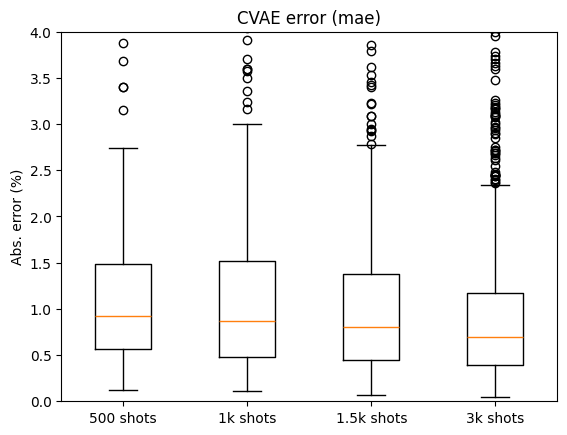

In [41]:
error_dist=[100*cvae_error_500,
            100*cvae_error_1k,
            100*cvae_error_1500,
            100*cvae_error]
labels=['500 shots','1k shots','1.5k shots','3k shots',]
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,4)
plt.ylabel('Abs. error (%)')
plt.title('CVAE error (mae)')

        Error Dataset Model
0    2.605777     500    RF
1    0.414910     500    RF
2    1.305463     500    RF
3    0.923211     500    RF
4    0.642008     500    RF
..        ...     ...   ...
810  0.346261    3000  CVAE
811  0.648639    3000  CVAE
812  0.877197    3000  CVAE
813  0.728918    3000  CVAE
814  0.545529    3000  CVAE

[3494 rows x 3 columns]


(0.0, 3.0)

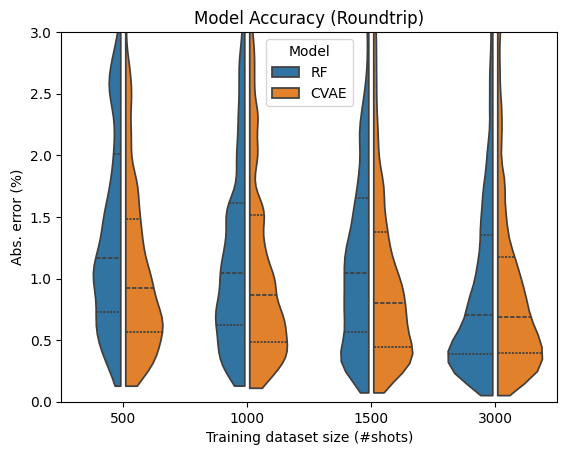

In [42]:
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='v')
plt.ylabel('Abs. error (%)')
plt.xlabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Roundtrip)')
plt.ylim(0,3)

        Error Dataset Model
0    2.605777     500    RF
1    0.414910     500    RF
2    1.305463     500    RF
3    0.923211     500    RF
4    0.642008     500    RF
..        ...     ...   ...
810  0.346261    3000  CVAE
811  0.648639    3000  CVAE
812  0.877197    3000  CVAE
813  0.728918    3000  CVAE
814  0.545529    3000  CVAE

[3494 rows x 3 columns]


(0.0, 3.0)

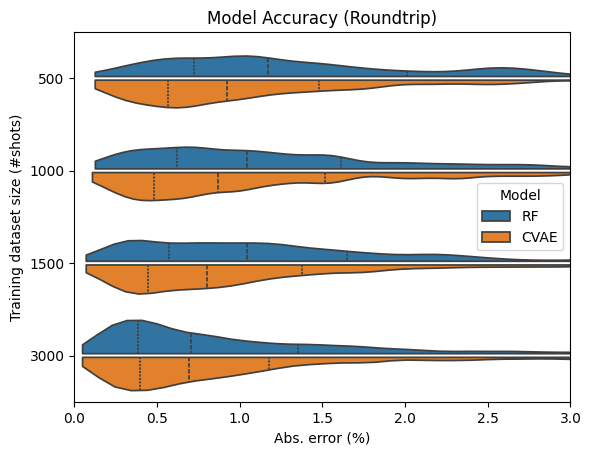

In [43]:
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)

sns.violinplot(data=df_plot,y='Dataset',x='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,3)

0      0.045915
1      0.046102
2      0.051315
3      0.102374
4      0.041380
         ...   
810    0.064137
811    0.041645
812    0.034969
813    0.032771
814    0.009011
Length: 815, dtype: float64
        Error Dataset Model
0    2.605777     500    RF
1    0.414910     500    RF
2    1.305463     500    RF
3    0.923211     500    RF
4    0.642008     500    RF
..        ...     ...   ...
810  0.346261    3000  CVAE
811  0.648639    3000  CVAE
812  0.877197    3000  CVAE
813  0.728918    3000  CVAE
814  0.545529    3000  CVAE

[3494 rows x 3 columns]


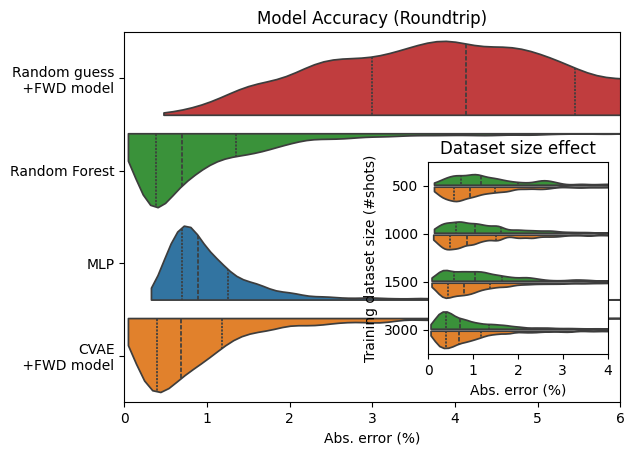

In [44]:
fig = plt.figure() #fig needed to add_axes later
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,6)

#inset plot (the datasize effect)
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)
ax = fig.add_axes([0.60, 0.21, 0.28, 0.40], facecolor='white') #[left, bottom, width, height]

sns.violinplot(data=df_plot,y='Dataset',x='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:green','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.ylabel('Training dataset size (#shots)')
plt.title('Dataset size effect')
plt.xlim(0,4)
ax.get_legend().remove()

## Custom shots

In [45]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_cust_cvae(y_ex,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,device):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Custom shot',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.xlabel('t(fs)',size=15)
    plt.ylabel('Intensity',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 2)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 3)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred. $P(\beta_4|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

In [46]:
#define the curve to fit
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


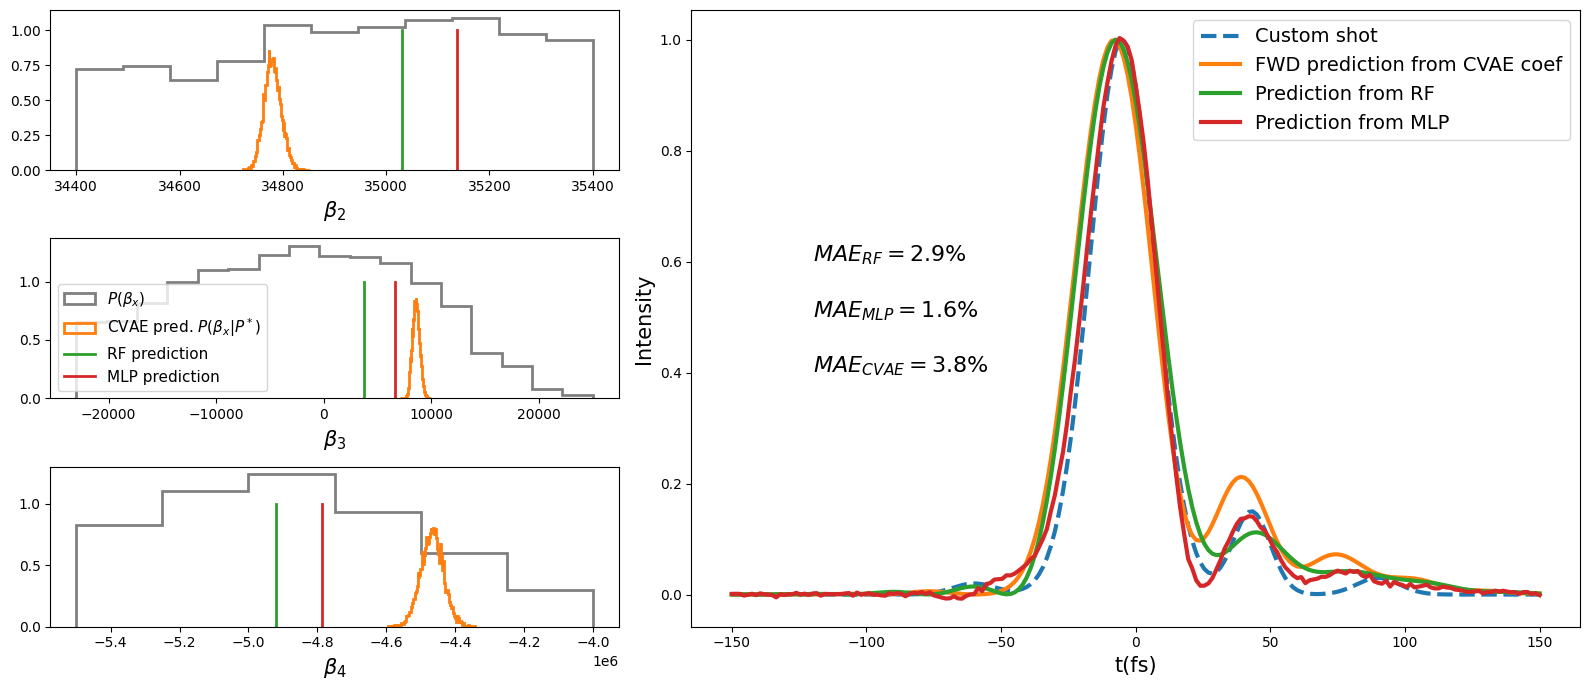

In [47]:
#y_cust_shot=func(t_200,1,-5,12,
#       0.03,+90,8,
#      0.15,+43,8,
#      0.04,-60,8,
#    0.01,0,0.1)

y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


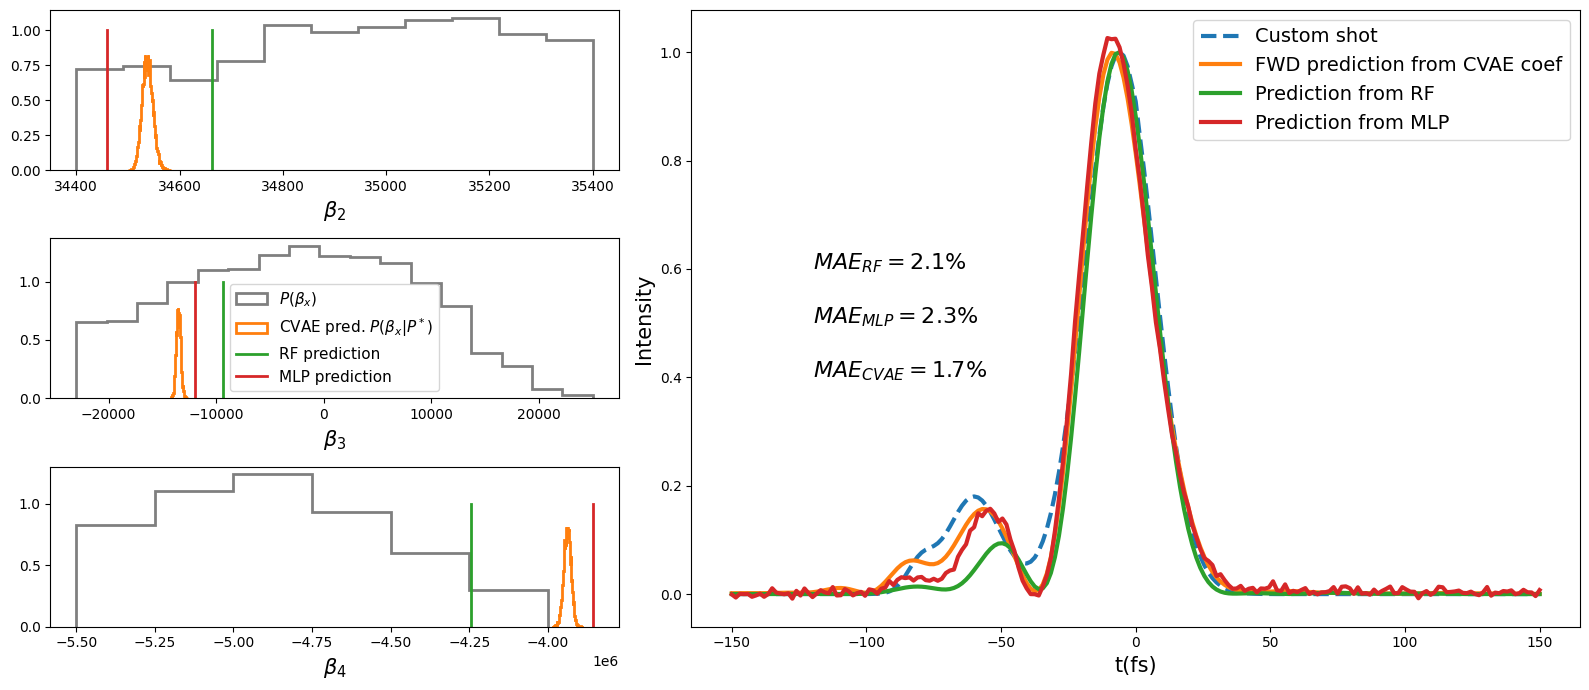

In [48]:
y_cust_shot=func(t_200,1,-6,13,
       0.05,-80,5,
      0.18,-60,10,
      0.,60,8,
    0.01,0,0.1)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


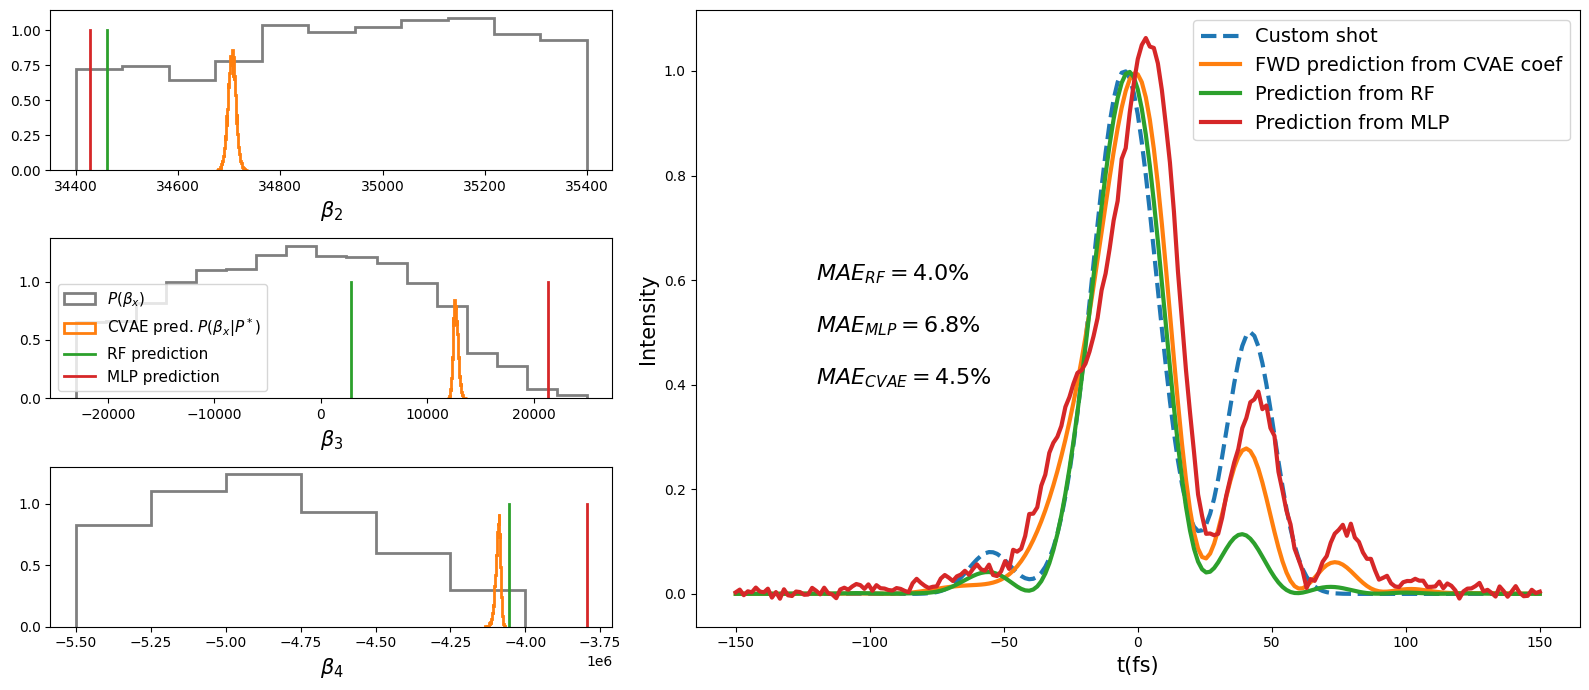

In [49]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.08,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


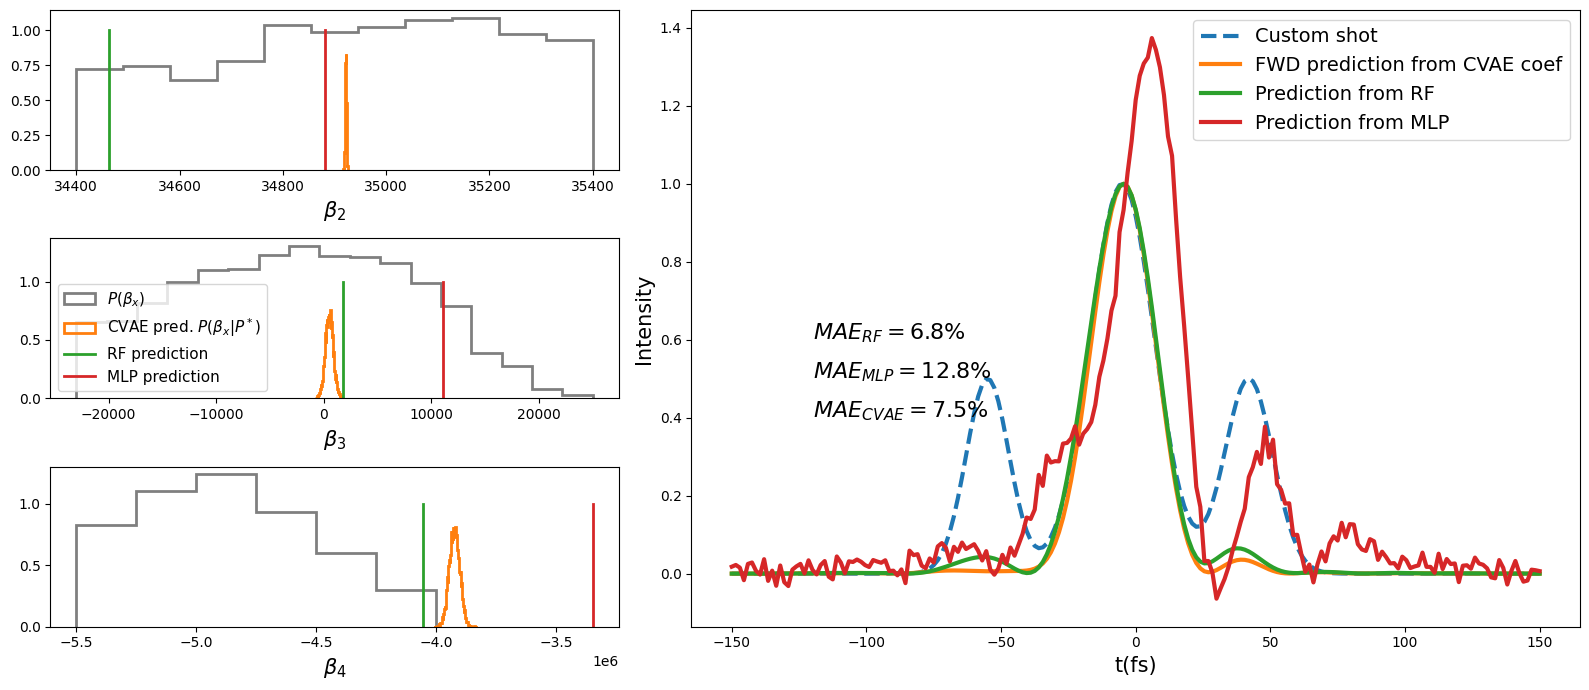

In [50]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.5,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


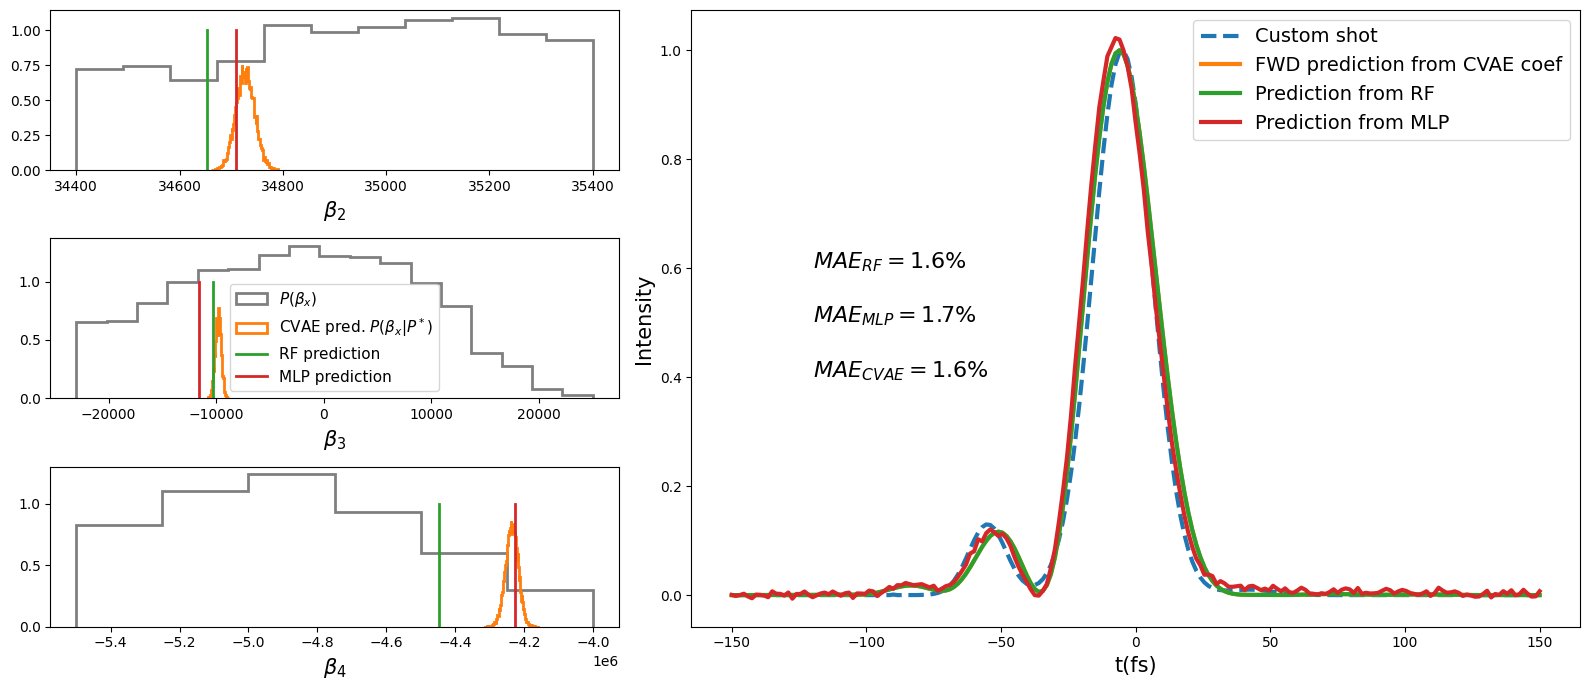

In [51]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.13,-55,7,
                 1,-5,11,
                 0.01,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


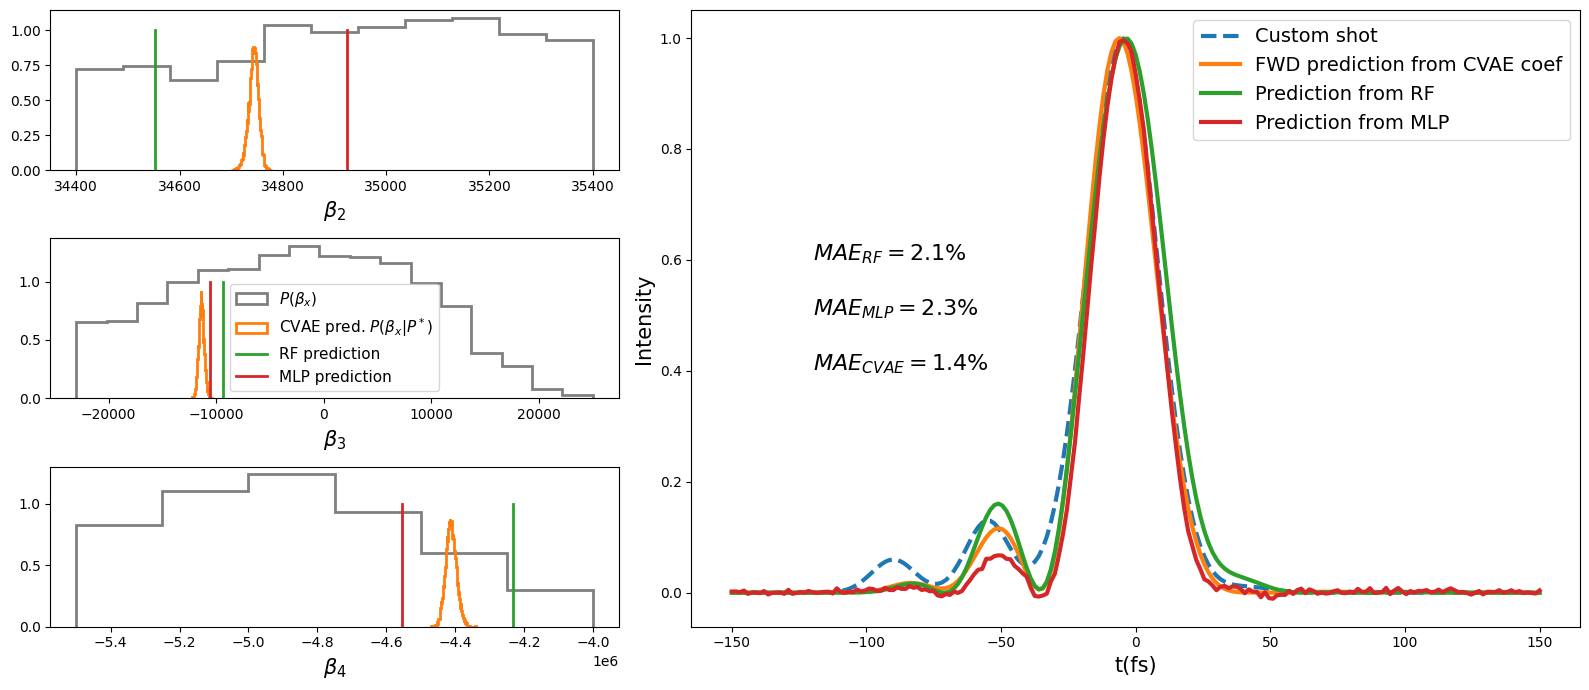

In [52]:
y_cust_shot=func(t_200,
                 0.06,-90,8,
                 0.13,-55,8,
                 1,-5,13,
                 0.01,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


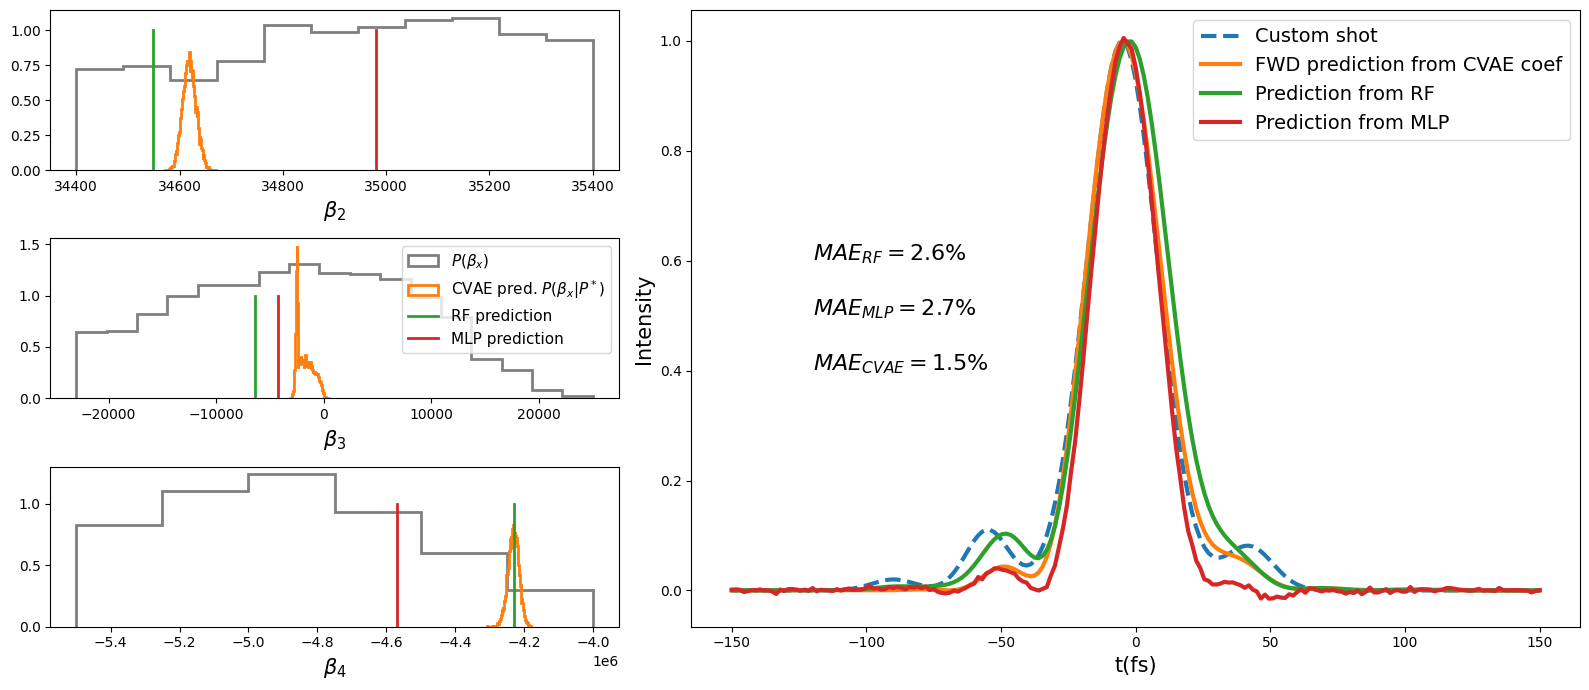

In [53]:
y_cust_shot=func(t_200,
                 0.02,-90,8,
                 0.11,-55,8,
                 1,-5,13,
                 0.08,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)